## Import Library

In [1]:
from __future__ import division, print_function
from gensim import models
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding
from keras.layers import LSTM, Bidirectional
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os
import collections
import re
import string

## Read data

In [2]:
data = pd.read_csv('faq2.csv')

In [3]:
data

,question,label,tag
0,halo,greets,greeting
1,hai,greets,greeting
2,hi,greets,greeting
3,selamat pagi,greets,greeting
4,selamat siang,greets,greeting
...,...,...,...
915,ok bye,greets,closing
916,makasi,greets,closing
917,makasih,greets,closing
918,terimakasih,greets,closing


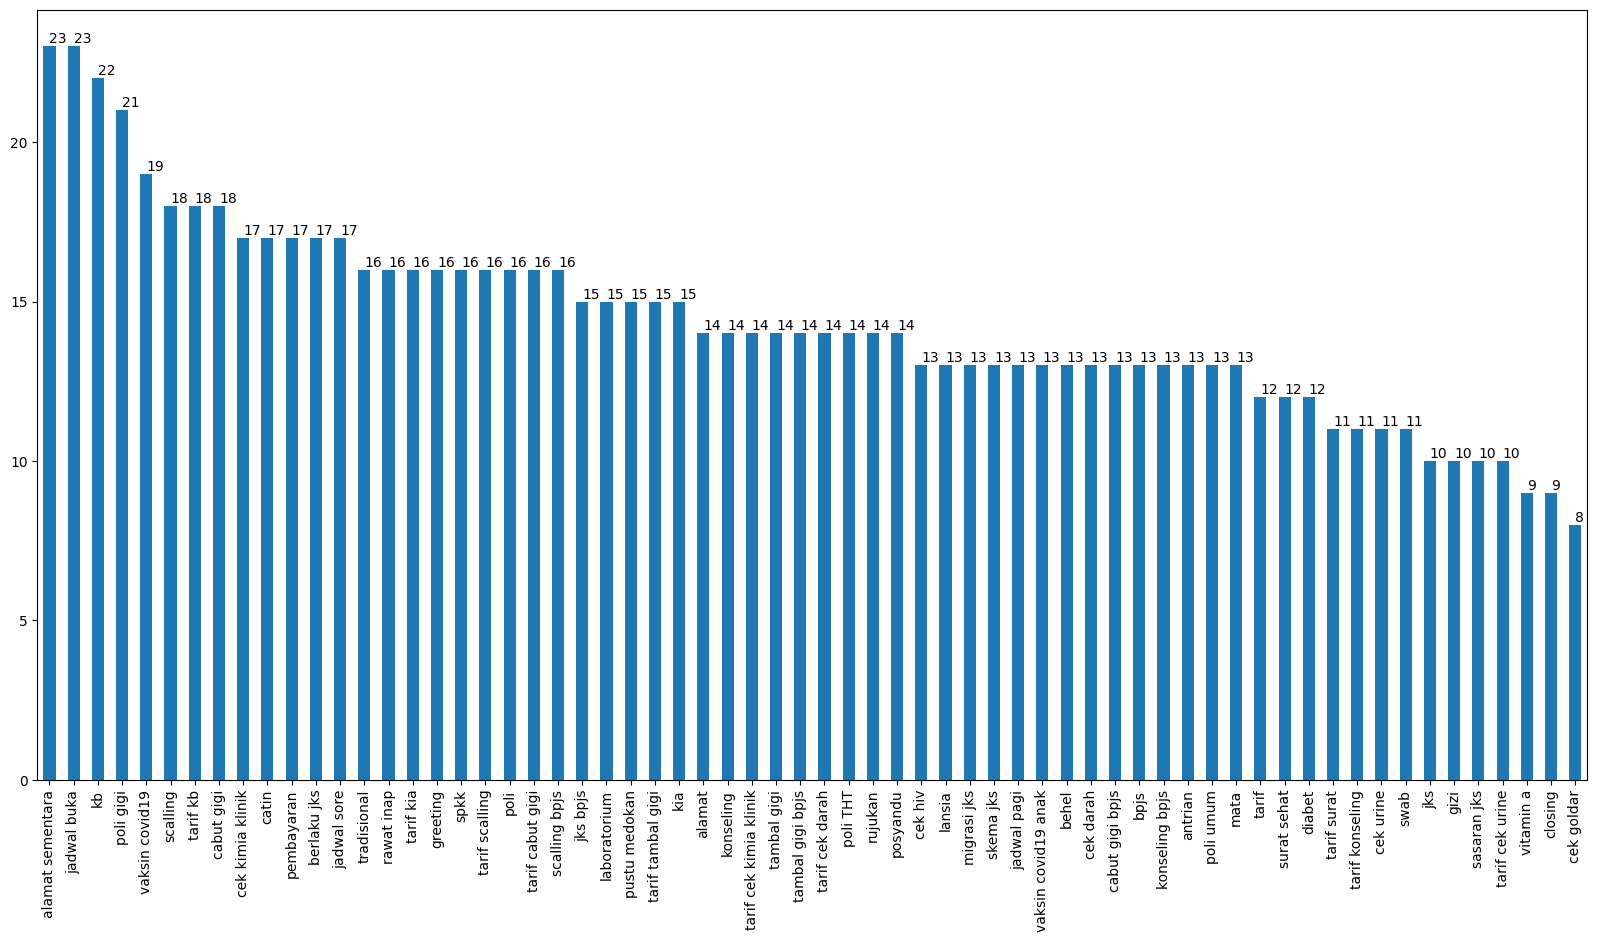

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
fig , ax = plt.subplots(1,1)
fig.set_size_inches(20,10)
s = data["tag"].value_counts()
fig = s.plot.bar(ax)
for i, v in s.reset_index().iterrows():
    fig.text(i, v.tag + 0.1 , v.tag, color='black')


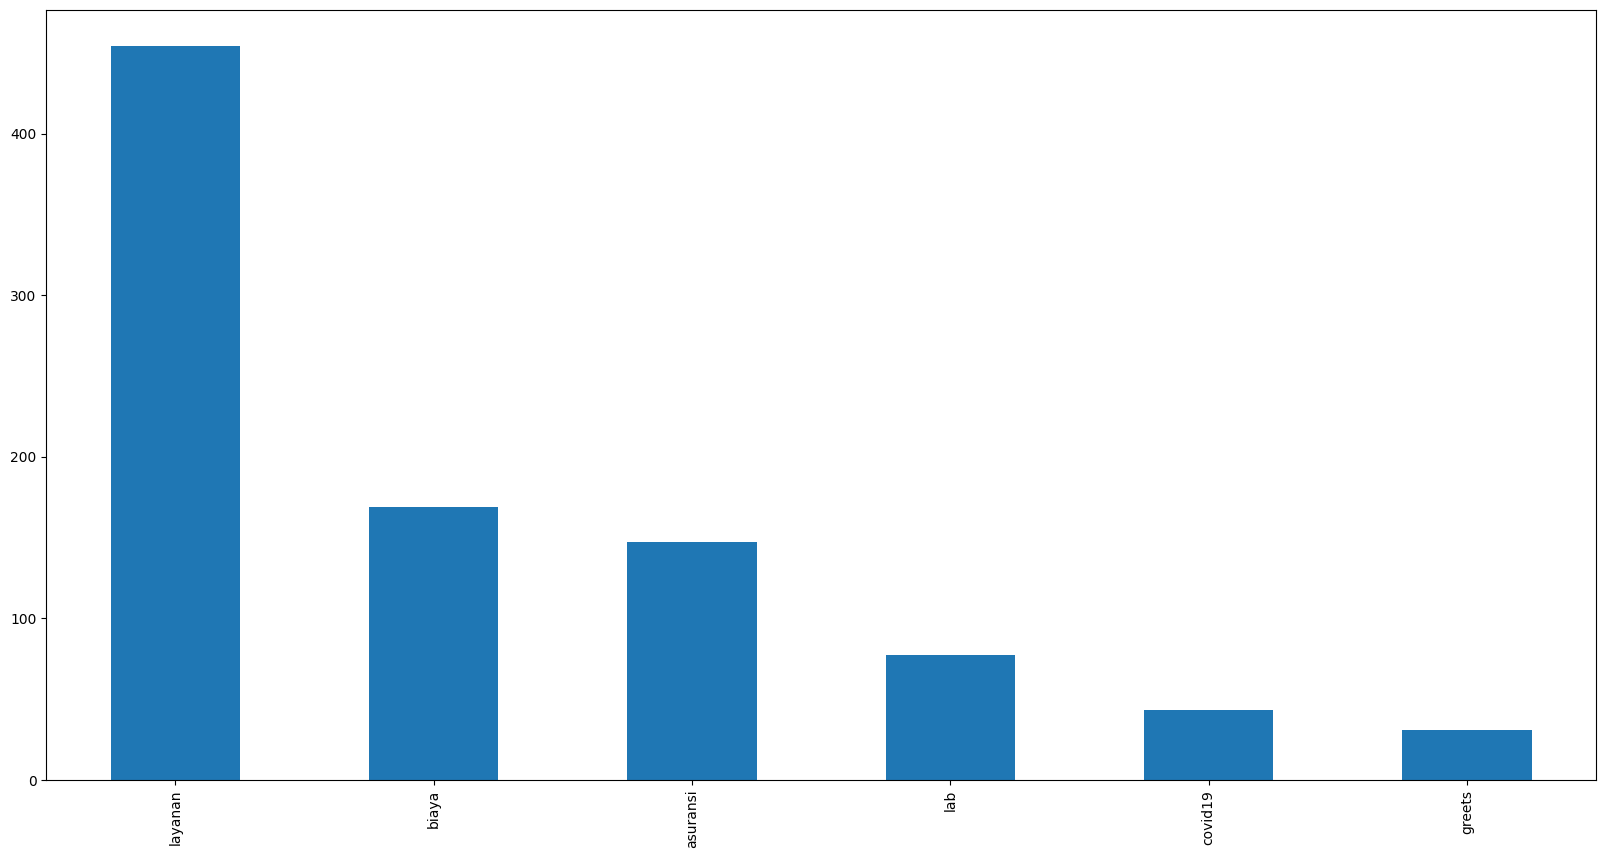

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
fig , ax = plt.subplots(1,1)
fig.set_size_inches(20,10)
fig = data["label"].value_counts().plot.bar(ax)

In [5]:
tag = data.tag.values
tag

array(['greeting', 'greeting', 'greeting', 'greeting', 'greeting',
       'greeting', 'greeting', 'greeting', 'greeting', 'greeting',
       'greeting', 'greeting', 'greeting', 'greeting', 'greeting',
       'greeting', 'alamat', 'alamat', 'alamat', 'alamat', 'alamat',
       'alamat', 'alamat', 'alamat', 'alamat', 'alamat', 'alamat',
       'alamat', 'alamat', 'alamat', 'alamat sementara',
       'alamat sementara', 'alamat sementara', 'alamat sementara',
       'alamat sementara', 'alamat sementara', 'alamat sementara',
       'alamat sementara', 'alamat sementara', 'alamat sementara',
       'alamat sementara', 'alamat sementara', 'alamat sementara',
       'alamat sementara', 'alamat sementara', 'alamat sementara',
       'alamat sementara', 'alamat sementara', 'alamat sementara',
       'alamat sementara', 'alamat sementara', 'alamat sementara',
       'alamat sementara', 'jadwal buka', 'jadwal buka', 'jadwal buka',
       'jadwal buka', 'jadwal buka', 'jadwal buka', 'jadwal buka'

In [5]:
label = data.label.values
label

array(['greets', 'greets', 'greets', 'greets', 'greets', 'greets',
       'greets', 'greets', 'greets', 'greets', 'greets', 'greets',
       'greets', 'greets', 'greets', 'greets', 'greets', 'greets',
       'greets', 'greets', 'greets', 'greets', 'layanan', 'layanan',
       'layanan', 'layanan', 'layanan', 'layanan', 'layanan', 'layanan',
       'layanan', 'layanan', 'layanan', 'layanan', 'layanan', 'layanan',
       'layanan', 'layanan', 'layanan', 'layanan', 'layanan', 'layanan',
       'layanan', 'layanan', 'layanan', 'layanan', 'layanan', 'layanan',
       'layanan', 'layanan', 'layanan', 'layanan', 'layanan', 'layanan',
       'layanan', 'layanan', 'layanan', 'layanan', 'layanan', 'layanan',
       'layanan', 'layanan', 'layanan', 'layanan', 'layanan', 'layanan',
       'layanan', 'layanan', 'layanan', 'layanan', 'layanan', 'layanan',
       'layanan', 'layanan', 'layanan', 'layanan', 'layanan', 'layanan',
       'layanan', 'layanan', 'layanan', 'layanan', 'layanan', 'layanan',


In [6]:
isi = data.question.values
isi

array(['halo', 'hai', 'hi', 'selamat pagi', 'selamat siang',
       'selamat sore', 'selamat malam',
       'permisi ini cs pukesmas keputih?',
       'ini benar kontaknya puskesmas keputih?', 'hei',
       'halo selamat pagi', 'halo selamat siang', 'hai selamat sore',
       'hai selamat malam', 'haloo', 'assalamualaikum',
       'alamat Puskesmas Keputih dimana?',
       'Puskesmas Keputih alamatnya dimana?', 'Puskesmas Keputih dmn?',
       'Puskesmas Keputih dimana ya?', 'Alamat puskesmas dmn yaa',
       'alamat lengkapnya apa?', 'alamatnya dimana?',
       'Puskesmas Keputih itu dimana ya?',
       'alamat lengkap puskesmas dimana?',
       'puskesmas keputih di sebelah mana ya',
       'puskesmasnya sebalah mana ya', 'alamatnya mana?',
       'puskesmas keputih di jalan apa',
       'alamatnya di jalan apa nomor berapa?', 'puskesmasnya apa pindah?',
       'alamat baru puskesmas keputih?',
       'puskesmas keputih pindah kemana', 'alamat yang baru dmn yaa?',
       'puskemas pi

In [7]:
isi.shape

(920,)

In [8]:
label_u = pd.unique(label)
label_u = label_u.tolist()

labels = dict()
for i in range(len(label_u)) :
    labels[i] = label_u[i]
labels

{0: 'greets', 1: 'layanan', 2: 'asuransi', 3: 'biaya', 4: 'lab', 5: 'covid19'}

In [8]:
cls = []
kategori_u = pd.unique(tag)
kategori_u = kategori_u.tolist()
for i in range(len(tag)):
    one_hot = np.zeros((len(kategori_u),), dtype=int)
    idx = kategori_u.index(tag[i])
    one_hot[idx] = 1
    cls.append(one_hot)
cls = np.array(cls)

In [9]:
id2tag = dict()
for i in range(len(kategori_u)) :
    id2tag[i] = kategori_u[i]
id2tag

{0: 'greeting',
 1: 'alamat',
 2: 'alamat sementara',
 3: 'jadwal buka',
 4: 'jadwal pagi',
 5: 'jadwal sore',
 6: 'poli',
 7: 'poli THT',
 8: 'poli gigi',
 9: 'scalling',
 10: 'scalling bpjs',
 11: 'tarif scalling',
 12: 'cabut gigi',
 13: 'cabut gigi bpjs',
 14: 'tarif cabut gigi',
 15: 'tambal gigi',
 16: 'tambal gigi bpjs',
 17: 'tarif tambal gigi',
 18: 'behel',
 19: 'konseling',
 20: 'konseling bpjs',
 21: 'tarif konseling',
 22: 'posyandu',
 23: 'antrian',
 24: 'rujukan',
 25: 'poli umum',
 26: 'pembayaran',
 27: 'tarif',
 28: 'bpjs',
 29: 'surat sehat',
 30: 'tarif surat',
 31: 'mata',
 32: 'spkk',
 33: 'vitamin a',
 34: 'catin',
 35: 'kia',
 36: 'tarif kia',
 37: 'kb',
 38: 'tarif kb',
 39: 'tradisional',
 40: 'laboratorium',
 41: 'cek darah',
 42: 'tarif cek darah',
 43: 'cek kimia klinik',
 44: 'tarif cek kimia klinik',
 45: 'cek hiv',
 46: 'cek urine',
 47: 'tarif cek urine',
 48: 'cek goldar',
 49: 'diabet',
 50: 'lansia',
 51: 'gizi',
 52: 'jks',
 53: 'jks bpjs',
 54: 'mi

In [10]:
import pickle
f = open('tag_lstm.pickle', 'wb')
pickle.dump(id2tag, f)
f.close()

In [10]:
print(isi.shape)
print(cls.shape)

(920,)
(920, 64)


## Preprocess

### Remove punctuation
Menghilangkan tanda baca 

In [11]:
def remove_punct(text):
    text_nopunct = ''
    text_nopunct = re.sub('['+string.punctuation+']', '', text)
    return text_nopunct

cleaned_text = []
for i in isi :
    cleaned_text.append(remove_punct(str(i)))
cleaned_text

['halo',
 'hai',
 'hi',
 'selamat pagi',
 'selamat siang',
 'selamat sore',
 'selamat malam',
 'permisi ini cs pukesmas keputih',
 'ini benar kontaknya puskesmas keputih',
 'hei',
 'halo selamat pagi',
 'halo selamat siang',
 'hai selamat sore',
 'hai selamat malam',
 'haloo',
 'assalamualaikum',
 'alamat Puskesmas Keputih dimana',
 'Puskesmas Keputih alamatnya dimana',
 'Puskesmas Keputih dmn',
 'Puskesmas Keputih dimana ya',
 'Alamat puskesmas dmn yaa',
 'alamat lengkapnya apa',
 'alamatnya dimana',
 'Puskesmas Keputih itu dimana ya',
 'alamat lengkap puskesmas dimana',
 'puskesmas keputih di sebelah mana ya',
 'puskesmasnya sebalah mana ya',
 'alamatnya mana',
 'puskesmas keputih di jalan apa',
 'alamatnya di jalan apa nomor berapa',
 'puskesmasnya apa pindah',
 'alamat baru puskesmas keputih',
 'puskesmas keputih pindah kemana',
 'alamat yang baru dmn yaa',
 'puskemas pindah dimana',
 'alamat puskesmas yang sekarang dimana',
 'puskesmas keputih pindahnya kemana ya',
 'sekarang pind

### Case Folding
Mengubah semua huruf ke lowercase menggunakan library nltk

In [12]:
tokens = []
for i in cleaned_text :
    sen = i.split()
    tokens.append(sen)
tokens

[['halo'],
 ['hai'],
 ['hi'],
 ['selamat', 'pagi'],
 ['selamat', 'siang'],
 ['selamat', 'sore'],
 ['selamat', 'malam'],
 ['permisi', 'ini', 'cs', 'pukesmas', 'keputih'],
 ['ini', 'benar', 'kontaknya', 'puskesmas', 'keputih'],
 ['hei'],
 ['halo', 'selamat', 'pagi'],
 ['halo', 'selamat', 'siang'],
 ['hai', 'selamat', 'sore'],
 ['hai', 'selamat', 'malam'],
 ['haloo'],
 ['assalamualaikum'],
 ['alamat', 'Puskesmas', 'Keputih', 'dimana'],
 ['Puskesmas', 'Keputih', 'alamatnya', 'dimana'],
 ['Puskesmas', 'Keputih', 'dmn'],
 ['Puskesmas', 'Keputih', 'dimana', 'ya'],
 ['Alamat', 'puskesmas', 'dmn', 'yaa'],
 ['alamat', 'lengkapnya', 'apa'],
 ['alamatnya', 'dimana'],
 ['Puskesmas', 'Keputih', 'itu', 'dimana', 'ya'],
 ['alamat', 'lengkap', 'puskesmas', 'dimana'],
 ['puskesmas', 'keputih', 'di', 'sebelah', 'mana', 'ya'],
 ['puskesmasnya', 'sebalah', 'mana', 'ya'],
 ['alamatnya', 'mana'],
 ['puskesmas', 'keputih', 'di', 'jalan', 'apa'],
 ['alamatnya', 'di', 'jalan', 'apa', 'nomor', 'berapa'],
 ['pusk

In [13]:
def lower_token(tokens): 
    return [w.lower() for w in tokens]    
    
lower_tokens = [lower_token(token) for token in tokens]

### slang words

In [14]:
import csv
with open('slang-words.csv', mode='r') as infile:
    reader = csv.reader(infile)
    mydict = {rows[0]:rows[1] for rows in reader}

mydict

{'slang': 'formal',
 'woww': 'wow',
 'aminn': 'amin',
 'met': 'selamat',
 'netaas': 'menetas',
 'keberpa': 'keberapa',
 'eeeehhhh': 'eh',
 'kata2nyaaa': 'kata-katanya',
 'hallo': 'halo',
 'kaka': 'kakak',
 'ka': 'kak',
 'daah': 'dah',
 'aaaaahhhh': 'ah',
 'yaa': 'ya',
 'smga': 'semoga',
 'slalu': 'selalu',
 'amiin': 'amin',
 'kk': 'kakak',
 'trus': 'terus',
 'sii': 'sih',
 'nyenengin': 'menyenangkan',
 'bgt': 'banget',
 'gemess': 'gemas',
 'akuuu': 'aku',
 'jgn': 'jangan',
 'udah': 'sudah',
 'gitu': 'begitu',
 'aja': 'saja',
 'gemesiin': 'menggemaskan',
 'menyenangkn': 'menyenangkan',
 'rb': 'ribu',
 'akau': 'aku',
 'saranin': 'menyarankan',
 'nemuin': 'menemukan',
 'yah': 'ya',
 'mnis2nya': 'manis-manisnya',
 'gtu': 'begitu',
 'tu': 'itu',
 'idolaa': 'idola',
 'bangett': 'banget',
 'kaakk': 'kak',
 'baaiikkk': 'baik',
 'telaatt': 'telat',
 'kaak': 'kak',
 'yg': 'yang',
 'lg': 'lagi',
 'skarang': 'sekarang',
 'sempet': 'sempat',
 'karna': 'karena',
 'ngga': 'enggak',
 'mantep': 'mantap

In [15]:
import pickle
f = open('slangs.pickle', 'wb')
pickle.dump(mydict, f)
f.close()

In [16]:
def replace_all(mylist, mydict):
    for i, j in mydict.items():
        for lst in mylist:
            if i in set(lst):
                # print("index", lst.index(i), "replace", j)
                lst[lst.index(i)] = j
        # print(mylist)
    return mylist

no_slang = replace_all(lower_tokens, mydict)
print(no_slang)

[['halo'], ['hai'], ['hi'], ['selamat', 'pagi'], ['selamat', 'siang'], ['selamat', 'sore'], ['selamat', 'malam'], ['permisi', 'ini', 'cs', 'pukesmas', 'keputih'], ['ini', 'benar', 'kontaknya', 'puskesmas', 'keputih'], ['hei'], ['halo', 'selamat', 'pagi'], ['halo', 'selamat', 'siang'], ['hai', 'selamat', 'sore'], ['hai', 'selamat', 'malam'], ['haloo'], ['assalamualaikum'], ['alamat', 'puskesmas', 'keputih', 'dimana'], ['puskesmas', 'keputih', 'alamatnya', 'dimana'], ['puskesmas', 'keputih', 'dimana'], ['puskesmas', 'keputih', 'dimana', 'ya'], ['alamat', 'puskesmas', 'dimana', 'ya'], ['alamat', 'lengkapnya', 'apa'], ['alamatnya', 'dimana'], ['puskesmas', 'keputih', 'itu', 'dimana', 'ya'], ['alamat', 'lengkap', 'puskesmas', 'dimana'], ['puskesmas', 'keputih', 'di', 'sebelah', 'mana', 'ya'], ['puskesmasnya', 'sebalah', 'mana', 'ya'], ['alamatnya', 'mana'], ['puskesmas', 'keputih', 'di', 'jalan', 'apa'], ['alamatnya', 'di', 'jalan', 'apa', 'nomor', 'berapa'], ['puskesmasnya', 'apa', 'pindah

In [17]:
re_noslang = [' '.join(sen) for sen in no_slang]
re_noslang

['halo',
 'hai',
 'hi',
 'selamat pagi',
 'selamat siang',
 'selamat sore',
 'selamat malam',
 'permisi ini cs pukesmas keputih',
 'ini benar kontaknya puskesmas keputih',
 'hei',
 'halo selamat pagi',
 'halo selamat siang',
 'hai selamat sore',
 'hai selamat malam',
 'haloo',
 'assalamualaikum',
 'alamat puskesmas keputih dimana',
 'puskesmas keputih alamatnya dimana',
 'puskesmas keputih dimana',
 'puskesmas keputih dimana ya',
 'alamat puskesmas dimana ya',
 'alamat lengkapnya apa',
 'alamatnya dimana',
 'puskesmas keputih itu dimana ya',
 'alamat lengkap puskesmas dimana',
 'puskesmas keputih di sebelah mana ya',
 'puskesmasnya sebalah mana ya',
 'alamatnya mana',
 'puskesmas keputih di jalan apa',
 'alamatnya di jalan apa nomor berapa',
 'puskesmasnya apa pindah',
 'alamat baru puskesmas keputih',
 'puskesmas keputih pindah kemana',
 'alamat yang baru dimana ya',
 'puskemas pindah dimana',
 'alamat puskesmas yang sekarang dimana',
 'puskesmas keputih pindahnya kemana ya',
 'sekara

### Import library sastrawi
Stemming bahasa Indonesia

In [18]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import string

### Stopword remover

In [19]:
factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()

In [20]:
def stopwords_remover(text) :
    text = stopword.remove(text)
    return text

In [21]:
res_stpw = [stopwords_remover(sen) for sen in re_noslang]
res_stpw

['halo',
 'hai',
 'hi',
 'selamat pagi',
 'selamat siang',
 'selamat sore',
 'selamat malam',
 'permisi cs pukesmas keputih',
 'benar kontaknya puskesmas keputih',
 'hei',
 'halo selamat pagi',
 'halo selamat siang',
 'hai selamat sore',
 'hai selamat malam',
 'haloo',
 'assalamualaikum',
 'alamat puskesmas keputih',
 'puskesmas keputih alamatnya',
 'puskesmas keputih',
 'puskesmas keputih ya',
 'alamat puskesmas ya',
 'alamat lengkapnya apa',
 'alamatnya',
 'puskesmas keputih dimana',
 'alamat lengkap puskesmas',
 'puskesmas keputih sebelah mana',
 'puskesmasnya sebalah mana',
 'alamatnya mana',
 'puskesmas keputih jalan apa',
 'alamatnya jalan apa nomor berapa',
 'puskesmasnya apa pindah',
 'alamat baru puskesmas keputih',
 'puskesmas keputih pindah',
 'alamat baru ya',
 'puskemas pindah',
 'alamat puskesmas sekarang',
 'puskesmas keputih pindahnya ya',
 'sekarang pindah ya',
 'alamat puskesmas',
 'alamat puskesmas keputih pindah',
 'memang puskesmasnya pindah',
 'pindah puskesmasnya

### Stemming

In [22]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [23]:
def stem(text) :
    text = stemmer.stem(text)
    return text

In [24]:
result_stemmed = [stem(sen) for sen in res_stpw]
result_stemmed

['halo',
 'hai',
 'hi',
 'selamat pagi',
 'selamat siang',
 'selamat sore',
 'selamat malam',
 'permisi cs pukesmas putih',
 'benar kontak puskesmas putih',
 'hei',
 'halo selamat pagi',
 'halo selamat siang',
 'hai selamat sore',
 'hai selamat malam',
 'haloo',
 'assalamualaikum',
 'alamat puskesmas putih',
 'puskesmas putih alamat',
 'puskesmas putih',
 'puskesmas putih ya',
 'alamat puskesmas ya',
 'alamat lengkap apa',
 'alamat',
 'puskesmas putih mana',
 'alamat lengkap puskesmas',
 'puskesmas putih belah mana',
 'puskesmas seba mana',
 'alamat mana',
 'puskesmas putih jalan apa',
 'alamat jalan apa nomor berapa',
 'puskesmas apa pindah',
 'alamat baru puskesmas putih',
 'puskesmas putih pindah',
 'alamat baru ya',
 'puskemas pindah',
 'alamat puskesmas sekarang',
 'puskesmas putih pindah ya',
 'sekarang pindah ya',
 'alamat puskesmas',
 'alamat puskesmas putih pindah',
 'memang puskesmas pindah',
 'pindah puskesmas',
 'alamat sesuai google kok tutup',
 'apa pindah',
 'sekarang pu

In [25]:
tokens = []
for i in result_stemmed :
    token = i.split()
    tokens.append(token)
tokens

[['halo'],
 ['hai'],
 ['hi'],
 ['selamat', 'pagi'],
 ['selamat', 'siang'],
 ['selamat', 'sore'],
 ['selamat', 'malam'],
 ['permisi', 'cs', 'pukesmas', 'putih'],
 ['benar', 'kontak', 'puskesmas', 'putih'],
 ['hei'],
 ['halo', 'selamat', 'pagi'],
 ['halo', 'selamat', 'siang'],
 ['hai', 'selamat', 'sore'],
 ['hai', 'selamat', 'malam'],
 ['haloo'],
 ['assalamualaikum'],
 ['alamat', 'puskesmas', 'putih'],
 ['puskesmas', 'putih', 'alamat'],
 ['puskesmas', 'putih'],
 ['puskesmas', 'putih', 'ya'],
 ['alamat', 'puskesmas', 'ya'],
 ['alamat', 'lengkap', 'apa'],
 ['alamat'],
 ['puskesmas', 'putih', 'mana'],
 ['alamat', 'lengkap', 'puskesmas'],
 ['puskesmas', 'putih', 'belah', 'mana'],
 ['puskesmas', 'seba', 'mana'],
 ['alamat', 'mana'],
 ['puskesmas', 'putih', 'jalan', 'apa'],
 ['alamat', 'jalan', 'apa', 'nomor', 'berapa'],
 ['puskesmas', 'apa', 'pindah'],
 ['alamat', 'baru', 'puskesmas', 'putih'],
 ['puskesmas', 'putih', 'pindah'],
 ['alamat', 'baru', 'ya'],
 ['puskemas', 'pindah'],
 ['alamat', 

In [26]:
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(tokens)
train = tokenizer.texts_to_sequences(tokens)
train

[[196],
 [197],
 [286],
 [101, 71],
 [101, 163],
 [101, 69],
 [101, 102],
 [287, 288, 229, 11],
 [198, 289, 1, 11],
 [290],
 [196, 101, 71],
 [196, 101, 163],
 [197, 101, 69],
 [197, 101, 102],
 [291],
 [292],
 [53, 1, 11],
 [1, 11, 53],
 [1, 11],
 [1, 11, 22],
 [53, 1, 22],
 [53, 199, 2],
 [53],
 [1, 11, 103],
 [53, 199, 1],
 [1, 11, 293, 103],
 [1, 294, 103],
 [53, 103],
 [1, 11, 200, 2],
 [53, 200, 2, 104, 3],
 [1, 2, 72],
 [53, 164, 1, 11],
 [1, 11, 72],
 [53, 164, 22],
 [230, 72],
 [53, 1, 138],
 [1, 11, 72, 22],
 [138, 72, 22],
 [53, 1],
 [53, 1, 11, 72],
 [295, 1, 72],
 [72, 1],
 [53, 296, 297, 231, 201],
 [2, 72],
 [138, 1],
 [2, 16, 232],
 [298, 299, 3],
 [53, 164, 2],
 [53, 72, 103],
 [1, 138, 232],
 [72],
 [53, 11, 300, 231, 63, 1],
 [138, 1, 72, 103],
 [5, 1, 11, 202, 38, 3],
 [1, 11, 32, 301, 38, 2],
 [54, 233, 32, 7],
 [62, 32],
 [1, 11, 32, 38, 3],
 [32, 54, 2],
 [32, 119, 54, 2],
 [1, 11, 32, 54, 7],
 [24, 165, 234, 233, 2],
 [165, 234, 1, 120, 32, 7],
 [54, 139, 1, 32,

In [27]:
train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))

Found 419 unique tokens.


In [28]:
MAX_SEQUENCE_LENGTH = 20
EMBEDDING_DIM = 300

In [29]:
X = pad_sequences(train, maxlen=MAX_SEQUENCE_LENGTH)
print(X)

[[  0   0   0 ...   0   0 196]
 [  0   0   0 ...   0   0 197]
 [  0   0   0 ...   0   0 286]
 ...
 [  0   0   0 ...   0  64 162]
 [  0   0   0 ...   0   0 418]
 [  0   0   0 ... 419  64 162]]


In [30]:
import pickle
f = open('tokenizer_cv_lstm.pickle', 'wb')
pickle.dump(tokenizer, f)
f.close()

## Embedding

In [32]:
word2vec_path = 'idwiki_word2vec_300_new.txt'
word2vec = models.KeyedVectors.load_word2vec_format(word2vec_path)

In [33]:
train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
for word,index in train_word_index.items():
    train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(train_embedding_weights.shape)

(420, 300)


## Create Model

In [34]:
num_words = len(train_word_index)+1
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[train_embedding_weights],
                            input_length=MAX_SEQUENCE_LENGTH)

In [35]:
X = np.array(X)
y = cls

#### With Cross-val

In [36]:
from sklearn.model_selection import KFold, StratifiedKFold

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
acc = []
loss = []
histories = []

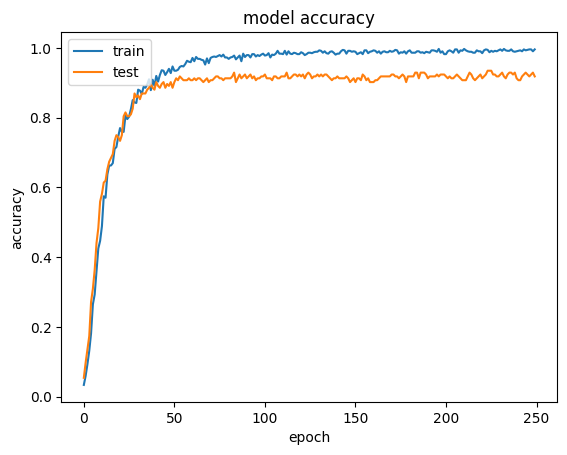

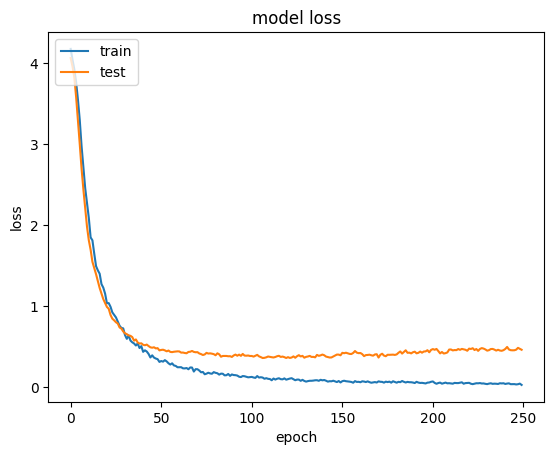

6/6 [==============================] - 1s 11ms/step
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         6
           3       1.00      0.75      0.86         8
           4       0.83      1.00      0.91         5
           5       0.67      1.00      0.80         2
           6       1.00      1.00      1.00         4
           8       0.80      1.00      0.89         4
           9       1.00      1.00      1.00         3
          10       0.00      0.00      0.00         0
          11       1.00      0.50      0.67         2
          12       1.00      0.83      0.91         6
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         5
          16       1.00      1.00      1.00         1
          17       1.00      

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

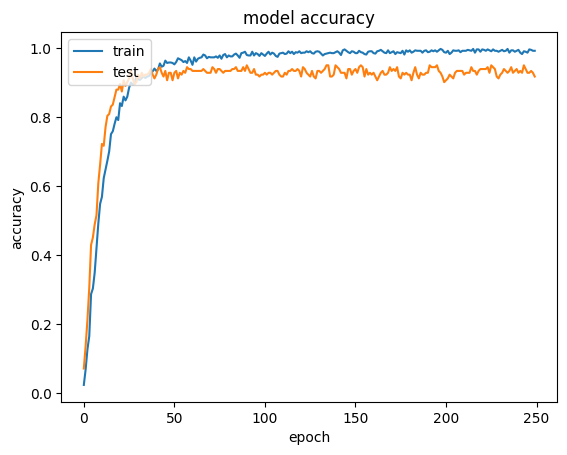

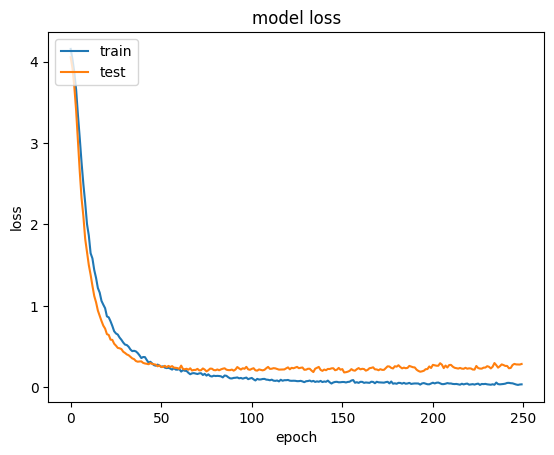

6/6 [==============================] - 1s 12ms/step
              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       1.00      1.00      1.00         5
           2       0.67      1.00      0.80         2
           3       1.00      0.83      0.91         6
           4       1.00      1.00      1.00         4
           5       0.67      1.00      0.80         2
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         4
           8       0.75      0.75      0.75         4
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         4
          12       0.80      1.00      0.89         4
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         1
          15       1.00      1.00      1.00         2
          16       1.00      

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

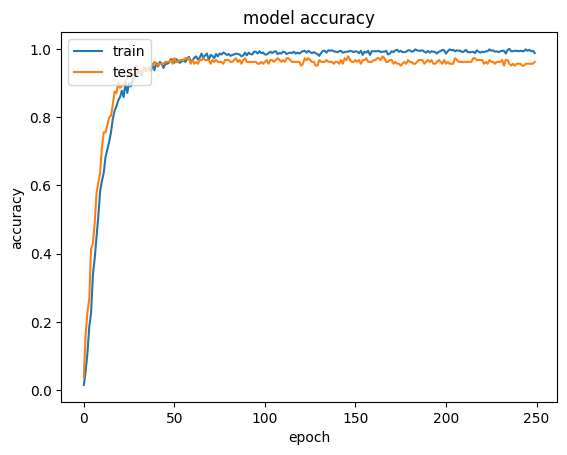

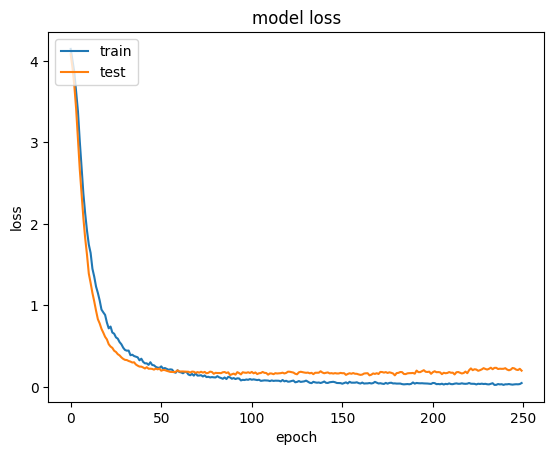

6/6 [==============================] - 1s 11ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.50      1.00      0.67         2
           2       1.00      0.80      0.89         5
           3       0.80      1.00      0.89         4
           4       1.00      1.00      1.00         1
           5       1.00      0.83      0.91         6
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         7
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         4
          15       1.00      1.00      1.00         3
          16       1.00      

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

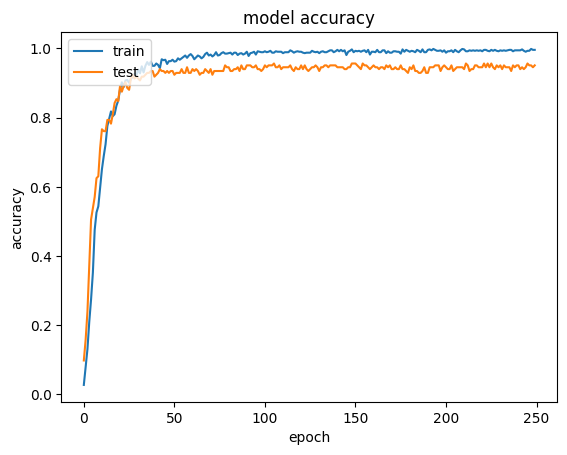

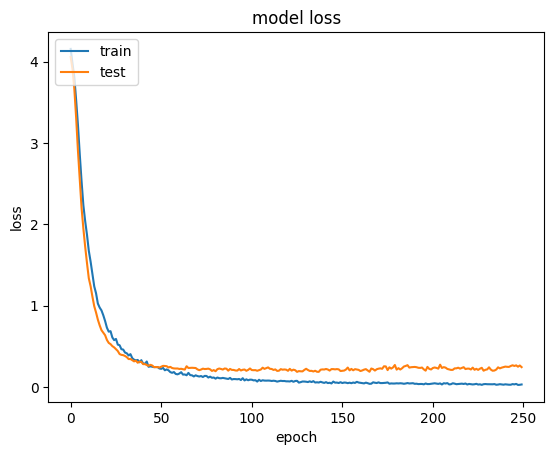

6/6 [==============================] - 1s 15ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.75      1.00      0.86         3
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         6
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         4
          11       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         3
          13       1.00      1.00      1.00         5
          14       1.00      1.00      1.00         2
          15       1.00      1.00      1.00         4
          16       1.00      1.00      1.00         1
          17       1.00      

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

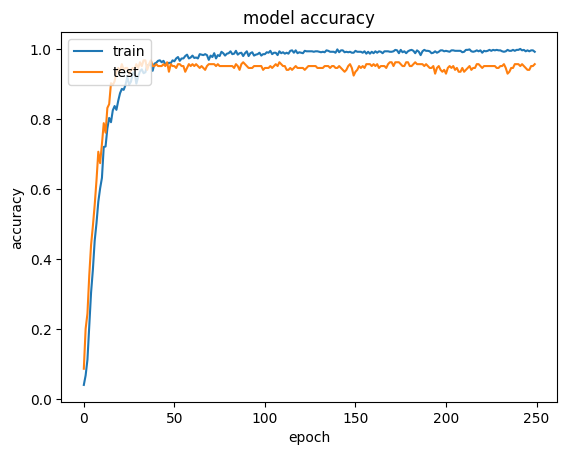

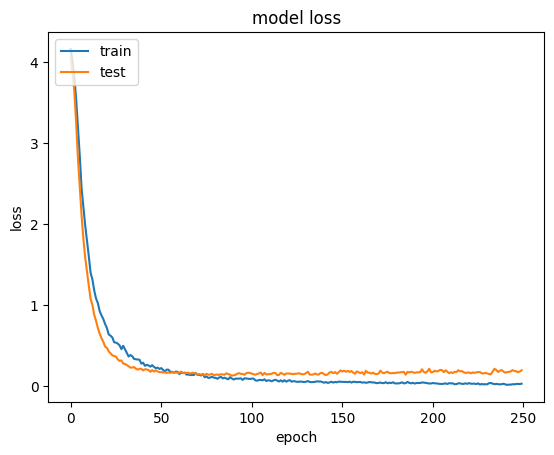

6/6 [==============================] - 1s 12ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      0.67      0.80         3
           2       0.86      1.00      0.92         6
           3       0.80      1.00      0.89         4
           4       1.00      1.00      1.00         3
           5       1.00      0.83      0.91         6
           6       1.00      0.50      0.67         2
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         5
          12       0.75      1.00      0.86         3
          13       1.00      1.00      1.00         1
          14       1.00      0.83      0.91         6
          16       1.00      1.00      1.00         4
          17       1.00      

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [37]:
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from datetime import datetime
import matplotlib.pyplot as plt

for train_index, test_index in kfold.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


    model = Sequential()
    model.add(embedding_layer)
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.5))
    model.add(LSTM(64))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation="softmax"))

    # opt = tf.keras.optimizers.SGD(learning_rate=0.1)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])

    curr = datetime.now().strftime("%Y%m%d%H%M%S")
    str_curr = str(curr)
    
    model_save = ModelCheckpoint('model_lstm_'+str_curr+'.hdf5', save_best_only= True, verbose=0)

    model.fit(X_train, y_train,validation_data=(X_test, y_test),epochs=250, shuffle=True,verbose=0, batch_size=32, callbacks=[model_save])
    
    plt.plot(model.history.history['acc'])
    plt.plot(model.history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(model.history.history['loss'])
    plt.plot(model.history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    scores = model.evaluate(X_test, y_test, verbose=0)
    pred = model.predict(X_test)
    y_pred = np.argmax(pred, axis=-1)
    y_test_list = []
    for i in y_test :
    #     print(i)
        for j in enumerate(i) :
            if j[1] == 1 :
                y_test_list.append(j[0])
    print(classification_report(y_test_list, y_pred))
    print("%s: %.2f%%" % (model.metrics_names[0], scores[0]*100))
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    loss.append(scores[0] * 100)
    acc.append(scores[1] * 100)
 
print("avg loss = %.2f%% (+/- %.2f%%)" % (np.mean(loss), np.std(loss)))
print("avg acc = %.2f%% (+/- %.2f%%)" % (np.mean(acc), np.std(acc)))

In [49]:
model.save('model_cv.hdf5')

#### End of Cross-val